In [24]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


In [25]:
forest_fires = fetch_ucirepo(id=162)

X = forest_fires.data.features
y = forest_fires.data.targets

print("Информация о датасете:")
print(forest_fires.metadata)
print("\nПеременные:")
print(forest_fires.variables)

print(f"\nРазмерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")
print(f"\nНазвания признаков: {list(X.columns)}")
print(f"Название целевой переменной: {list(y.columns)}")

Информация о датасете:
{'uci_id': 162, 'name': 'Forest Fires', 'repository_url': 'https://archive.ics.uci.edu/dataset/162/forest+fires', 'data_url': 'https://archive.ics.uci.edu/static/public/162/data.csv', 'abstract': 'This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).', 'area': 'Climate and Environment', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 517, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['area'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5D88D', 'creators': ['Paulo Cortez', 'Anbal Morais'], 'intro_paper': {'ID': 368, 'type': 'NATIVE', 'title': 'A data mining approach to predict forest fires 

In [26]:

X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

y_area = y_clean['area']

le_month = LabelEncoder()
le_day = LabelEncoder()

X_clean['month_encoded'] = le_month.fit_transform(X_clean['month'])
X_clean['day_encoded'] = le_day.fit_transform(X_clean['day'])

X_clean = X_clean.drop(['month', 'day'], axis=1)


y_encoded = y_area

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_encoded, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер train выборки: {X_train_scaled.shape}")
print(f"Размер test выборки: {X_test_scaled.shape}")
print(f"Количество признаков: {X_train_scaled.shape[1]}")


Размер train выборки: (413, 12)
Размер test выборки: (104, 12)
Количество признаков: 12


In [27]:
def create_base_model(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')
    ])
    return model

input_dim = X_train_scaled.shape[1]

base_model = create_base_model(input_dim)
base_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mse',
    metrics=['mae']
)

print("Архитектура базовой модели:")
base_model.summary()

Архитектура базовой модели:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_base = base_model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_base, test_mae_base = base_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nБазовая модель - Test MSE: {test_loss_base:.4f}")
print(f"Базовая модель - Test MAE: {test_mae_base:.4f}")

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 3144.6094 - mae: 13.8968 - val_loss: 585.0834 - val_mae: 9.9760 - learning_rate: 0.0100
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1150.7461 - mae: 13.1221 - val_loss: 574.1422 - val_mae: 10.5506 - learning_rate: 0.0100
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2055.2483 - mae: 15.6158 - val_loss: 573.6872 - val_mae: 12.3181 - learning_rate: 0.0100
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4039.2507 - mae: 20.7059 - val_loss: 551.9406 - val_mae: 12.0390 - learning_rate: 0.0100
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2204.3083 - mae: 16.0106 - val_loss: 534.7863 - val_mae: 10.5732 - learning_rate: 0.0100
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3458.3335 - mae: 16.3200 - val_loss: 543.1420 - val_mae: 10.6475 - learning_rate: 0.0100
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1111.5764 - mae: 13.8633 - val_loss: 582.5484 

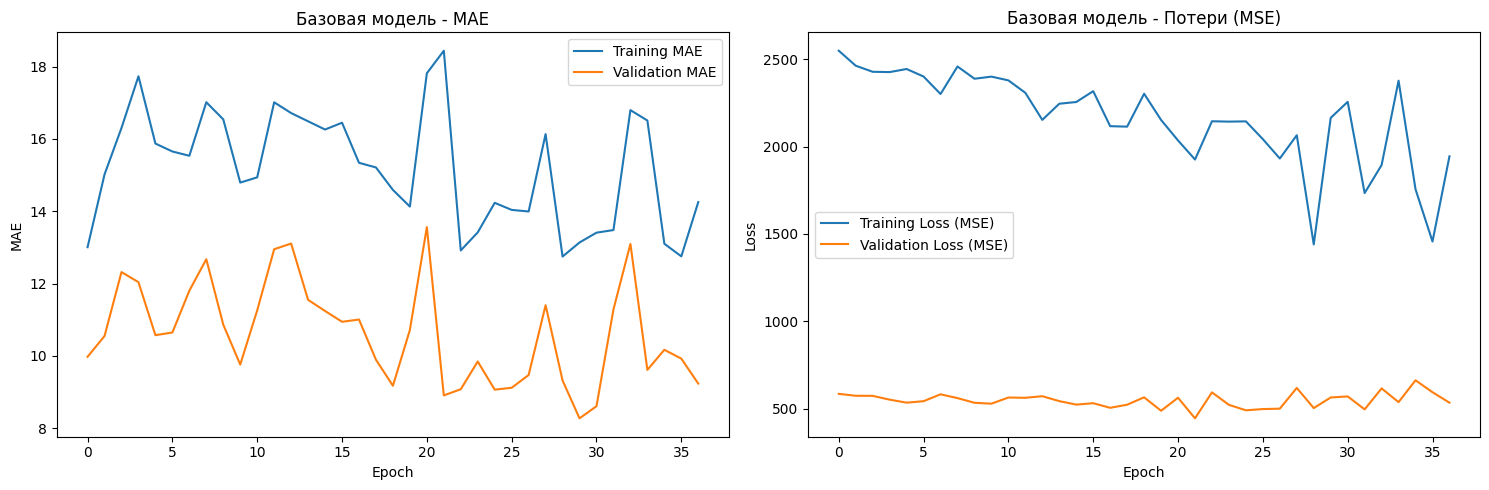

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_base.history['mae'], label='Training MAE')
plt.plot(history_base.history['val_mae'], label='Validation MAE')
plt.title('Базовая модель - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_base.history['loss'], label='Training Loss (MSE)')
plt.plot(history_base.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Базовая модель - Потери (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
print("АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ")

pretrained_weights = []

print("1. Обучение первого автоэнкодера:")
input_data = X_train_scaled
input_dim = X_train_scaled.shape[1]

encoder1 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,), name='encoder1')
])

decoder1 = models.Sequential([
    layers.Dense(input_dim, activation='linear', name='decoder1')
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder1.compile(optimizer='adam', loss='mse')

history1 = autoencoder1.fit(
    input_data, input_data,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Первый автоэнкодер обучен. Final loss: {history1.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder1.layers[0].get_weights())

print("2. Обучение второго автоэнкодера:")

encoded_data1 = encoder1.predict(input_data, verbose=0)

encoder2 = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(64,), name='encoder2')
])

decoder2 = models.Sequential([
    layers.Dense(64, activation='linear', name='decoder2')
])

autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder2.compile(optimizer='adam', loss='mse')

history2 = autoencoder2.fit(
    encoded_data1, encoded_data1,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Второй автоэнкодер обучен. Final loss: {history2.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder2.layers[0].get_weights())

print("3. Обучение третьего автоэнкодера:")
encoded_data2 = encoder2.predict(encoded_data1, verbose=0)

encoder3 = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(32,), name='encoder3')
])

decoder3 = models.Sequential([
    layers.Dense(32, activation='linear', name='decoder3')
])

autoencoder3 = models.Sequential([encoder3, decoder3])
autoencoder3.compile(optimizer='adam', loss='mse')

history3 = autoencoder3.fit(
    encoded_data2, encoded_data2,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

print(f"  Третий автоэнкодер обучен. Final loss: {history3.history['loss'][-1]:.4f}")
pretrained_weights.append(encoder3.layers[0].get_weights())

print("Все автоэнкодеры обучены!")

АВТОЭНКОДЕРНЫЙ ПОДХОД ДЛЯ ПРЕДОБУЧЕНИЯ
1. Обучение первого автоэнкодера:
  Первый автоэнкодер обучен. Final loss: 0.0073
2. Обучение второго автоэнкодера:
  Второй автоэнкодер обучен. Final loss: 0.0142
3. Обучение третьего автоэнкодера:
  Третий автоэнкодер обучен. Final loss: 0.0493
Все автоэнкодеры обучены!


In [31]:
print("СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ")

pretrained_model = models.Sequential()

pretrained_model.add(layers.Dense(64, activation='relu',
                                input_shape=(input_dim,),
                                name='pretrained_layer1'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(32, activation='relu',
                                name='pretrained_layer2'))
pretrained_model.add(layers.Dropout(0.3))

pretrained_model.add(layers.Dense(16, activation='relu',
                                name='pretrained_layer3'))
pretrained_model.add(layers.Dropout(0.2))

pretrained_model.add(layers.Dense(1, activation='linear',
                                name='output_layer'))

pretrained_model.layers[0].set_weights(pretrained_weights[0])
pretrained_model.layers[2].set_weights(pretrained_weights[1])
pretrained_model.layers[4].set_weights(pretrained_weights[2])

pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Архитектура модели с предобучением:")
pretrained_model.summary()

СОЗДАНИЕ ОСНОВНОЙ СЕТИ С ПРЕДОБУЧЕННЫМИ ВЕСАМИ
Архитектура модели с предобучением:


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pretrained_layer1 (Dense)       │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer2 (Dense)       │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pretrained_layer3 (Dense)       │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
print("ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА")

history_pretrained = pretrained_model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)
    ]
)

test_loss_pretrained, test_mae_pretrained = pretrained_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nМодель с предобучением - Test MSE: {test_loss_pretrained:.4f}")
print(f"Модель с предобучением - Test MAE: {test_mae_pretrained:.4f}")

ОБУЧЕНИЕ С УЧИТЕЛЕМ И ТОЧНАЯ НАСТРОЙКА
Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - loss: 1154.3397 - mae: 9.2990 - val_loss: 603.6815 - val_mae: 7.8519 - learning_rate: 0.0010
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1422.2538 - mae: 11.1736 - val_loss: 596.1021 - val_mae: 8.4034 - learning_rate: 0.0010
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3781.3818 - mae: 14.9235 - val_loss: 590.6372 - val_mae: 8.9096 - learning_rate: 0.0010
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5148.8779 - mae: 17.3500 - val_loss: 587.6558 - val_mae: 9.4009 - learning_rate: 0.0010
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1096.9827 - mae: 11.8850 - val_loss: 587.0720 - val_mae: 9.7100 - learning_rate: 0.0010
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2016.1035 - mae: 12.6079 - val_loss: 584.3000 - val_mae: 10.0731 - learning_rate: 0.0010
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1072.4755 - mae: 1

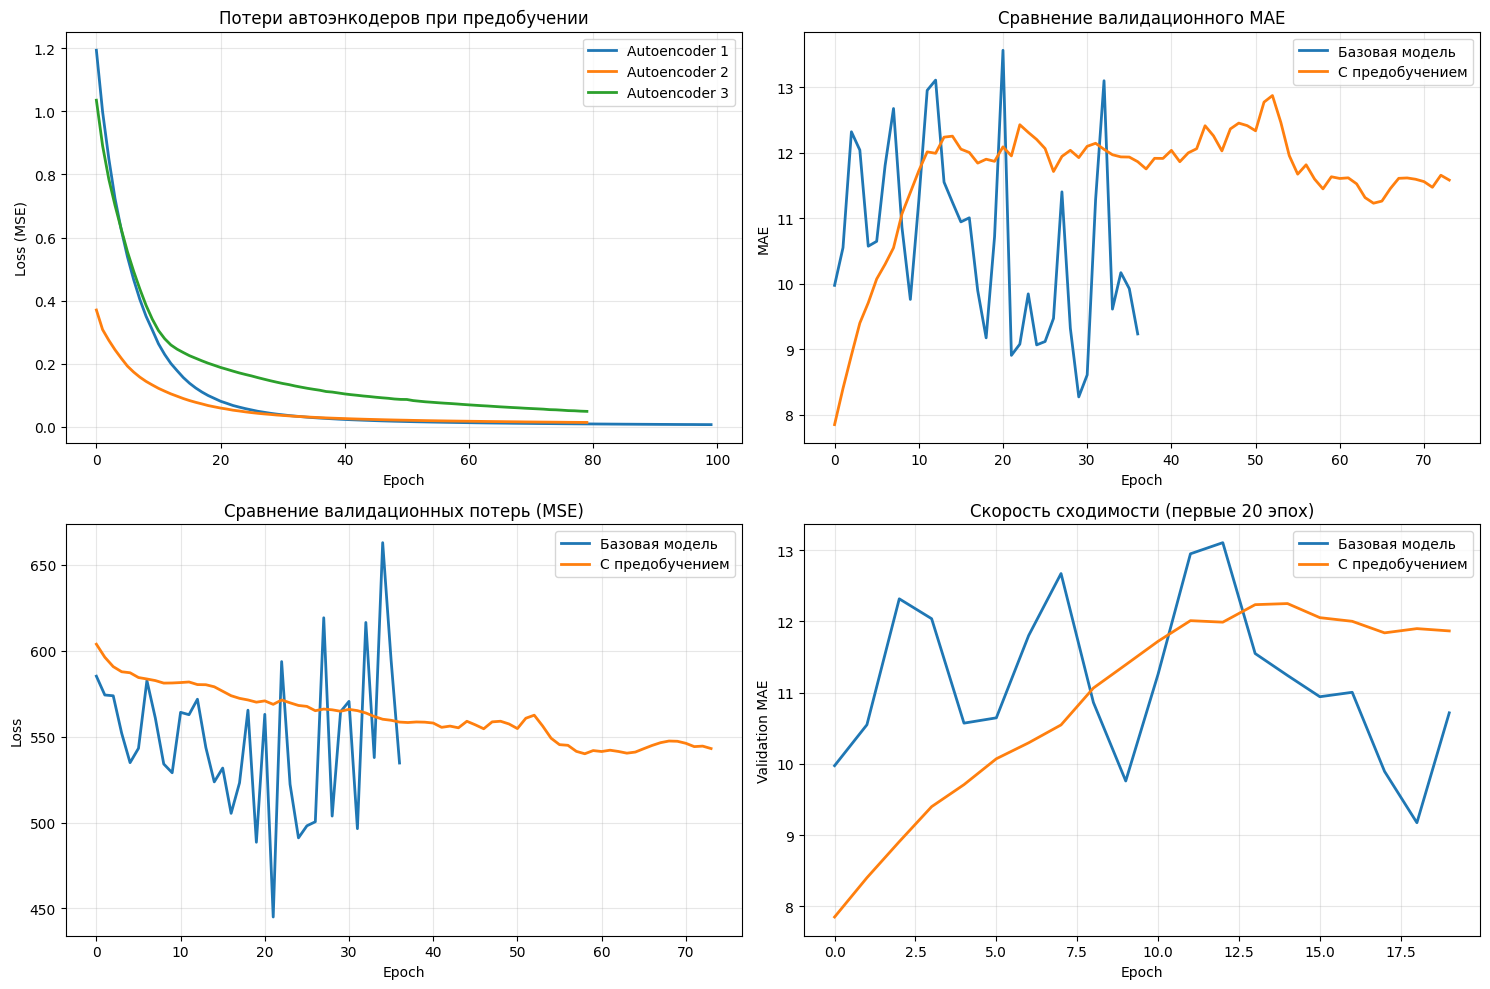

In [33]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], label='Autoencoder 1', linewidth=2)
plt.plot(history2.history['loss'], label='Autoencoder 2', linewidth=2)
plt.plot(history3.history['loss'], label='Autoencoder 3', linewidth=2)
plt.title('Потери автоэнкодеров при предобучении')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(history_base.history['val_mae'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_mae'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационного MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(history_base.history['val_loss'], label='Базовая модель', linewidth=2)
plt.plot(history_pretrained.history['val_loss'], label='С предобучением', linewidth=2)
plt.title('Сравнение валидационных потерь (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
min_epochs = min(len(history_base.history['val_mae']),
                 len(history_pretrained.history['val_mae']), 20)
plt.plot(range(min_epochs), history_base.history['val_mae'][:min_epochs],
         label='Базовая модель', linewidth=2)
plt.plot(range(min_epochs), history_pretrained.history['val_mae'][:min_epochs],
         label='С предобучением', linewidth=2)
plt.title('Скорость сходимости (первые 20 эпох)')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
